In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report, confusion_matrix
import warnings
import pickle

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("rupakroy/online-payments-fraud-detection-dataset")

print("Path to dataset files:", path)

100%|██████████| 178M/178M [00:06<00:00, 27.8MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/rupakroy/online-payments-fraud-detection-dataset/versions/1


In [3]:
import os
for root,dirs,files in os.walk(path):
    for file in files:
        print(file)

PS_20174392719_1491204439457_log.csv


In [8]:
data=os.path.join(path,"PS_20174392719_1491204439457_log.csv")
df=pd.read_csv(data)
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


# CHECKING FOR NULL VALUES

In [9]:
df.isnull().sum()

,0
step,0
type,0
amount,0
nameOrig,0
oldbalanceOrg,0
newbalanceOrig,0
nameDest,0
oldbalanceDest,0
newbalanceDest,0
isFraud,0


# HANDLING OUTLIERS

<Axes: xlabel='amount'>

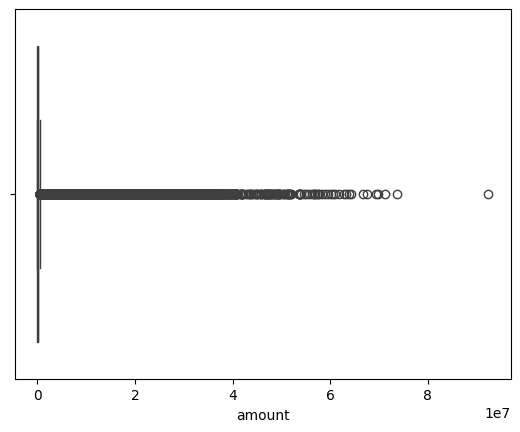

In [29]:
sns.boxplot(x=df['amount'])

In [12]:
from scipy import stats
print(stats.mode(df['amount']))
print(np.mean(df['amount']))
print(np.median(df['amount']))

ModeResult(mode=np.float64(10000000.0), count=np.int64(3207))
179861.90354913071
74871.94


In [13]:
q1=np.quantile(df['amount'],0.25)
q3=np.quantile(df['amount'],0.75)
IQR=q3-q1
upper_bound=q3+(1.5*IQR)
lower_bound=q1-(1.5*IQR)
print("q1 : ",q1)
print("q3 : ",q3)
print("IQR : ",IQR)
print("upper_bound : ",upper_bound)
print("lower_bound : ",lower_bound)
print("Skewed data: ",len(df['amount']>upper_bound))
print("Skewed data: ",len(df['amount']<lower_bound))

In [27]:
def transformationPlot(feature):
  plt.figure(figsize=(12,8))
  plt.subplot(1,2,1)
  sns.distplot(feature)
  plt.subplot(1,2,2)
  stats.probplot(feature,dist='norm',plot=plt)
  plt.show()

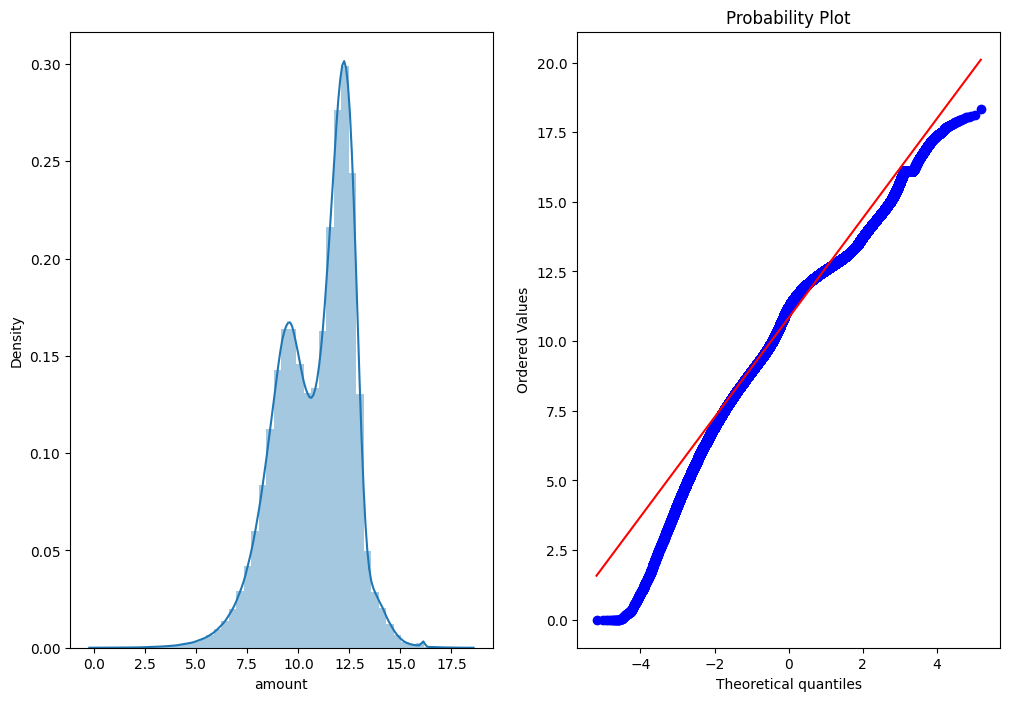

In [28]:
transformationPlot(np.log1p(df['amount']))

# OBJECT DATA LABEL_ENCODING

In [31]:
from sklearn.preprocessing import(LabelEncoder)
le=LabelEncoder()
df['type']=le.fit_transform(df['type'])
df['type'].value_counts()

,count
type,
1,2237500
3,2151495
0,1399284
4,532909
2,41432


In [32]:
x=df.drop('isFraud',axis=1)
y=df['isFraud']
x

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFlaggedFraud
0,1,3,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0
1,1,3,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0
2,1,4,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,0
3,1,1,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,0
4,1,3,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0
...,...,...,...,...,...,...,...,...,...,...
6362615,743,1,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,0
6362616,743,4,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,0
6362617,743,1,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,0
6362618,743,4,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,0


In [33]:
y

,isFraud
0,0
1,0
2,1
3,1
4,0
...,...
6362615,1
6362616,1
6362617,1
6362618,1


# SPLITTING DATA INTO TRAIN AND TEST

In [35]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=0,test_size=0.2)

In [36]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(5090096, 10)
(1272524, 10)
(5090096,)
(1272524,)
